# ML4CV: Style transfer - project work
Student: Chiara Brunelli

e-mail: chiara.brunelli5@studio.unibo.it

ID unibo: 0001026865

In this notebook, we implement the method proposed in the paper [*Instance Normalization: The Missing Ingredient for Fast Stylization*](https://arxiv.org/abs/1607.08022) by Ulyanov et al. The goal of the paper is to demonstrate that, by replacing batch normalization with instance normalization, feed-forward image transformation networks can achieve stylization results comparable to the Neural Style Transfer method of Gatys et al., while maintaining real-time inference.

The implemented model learns to transfer the artistic style of a fixed style image to arbitrary content images, enabling real-time stylization after training. The approach follows the perceptual loss framework, where content and style representations are extracted using a pretrained convolutional neural network.

Our approach to reproducing the main results of the paper focuses on investigating the effect of adding noise to the content images during training. In particular, we study whether and how injecting gaussian noise and salt-and-pepper noise influences the quality of the stylized outputs.

## Set-up

### Import Dependencies
Let's import the necessary libraries

In [ ]:
import os
import time
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms, utils
from datasets import load_dataset

import glob
import zipfile

import gc

And connect the repository containing the style and content images.

In [ ]:
!git clone https://github.com/chiara-b/ML4CV_project.git
os.chdir('ML4CV_project')

Cloning into 'ML4CV_project'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 251 (delta 4), reused 7 (delta 3), pack-reused 243 (from 1)
Receiving objects: 100% (251/251), 2.37 GiB | 29.33 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (131/131), done.


### Enviroment variables

In [ ]:
# PATHS
COCO_PATH = "/content/coco/"

BASELINE_DICT_PATH = "/content/ML4CV_project/net_dict_baseline/"
SP_DICT_PATH = "/content/ML4CV_project/net_dict_salt_pepper/"
GAU_DICT_PATH = "/content/ML4CV_project/net_dict_gaussian/"

# GLOBALS VARIABLE
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 286
CROP_SIZE = 256

# HYPER-PARAMETERS
BATCH_SIZE = 4

### Runtime Settings

In [ ]:
device = "cpu"
if torch.cuda.is_available:
    print('All good, a Gpu is available')
    device = torch.device("cuda:0")
    torch.set_default_device(device)
else:
    print('Please set GPU via Edit -> Notebook Settings.')

All good, a Gpu is available


## Dataset

For training the style transfer network, we use images from the COCO dataset. Specifically, we download and use the validation split of COCO 2014 (val2014). These images are used as content images during training, while the style image is kept fixed and selected from the repository.

So let's download the COCO dataset:

In [ ]:
!mkdir -p {COCO_PATH}
%cd {COCO_PATH}

!wget -c http://images.cocodataset.org/zips/val2014.zip
!unzip -n val2014.zip

In addition to the COCO dataset used for training, we'll need some content images used for qualitative evaluation an the style image, which are selected from publicly available Kaggle datasets.

Specifically, the content images used for evaluation are taken from the [*Small image dataset for unsupervised clustering*](https://www.kaggle.com/datasets/heavensky/image-dataset-for-unsupervised-clustering).

The style image is instead selected from the [*Artistic Style Transfer from Paintings HD*](https://www.kaggle.com/datasets/momincks/paintings-for-artistic-style-transfer) dataset, which provides high-resolution paintings commonly used in artistic style transfer tasks.

In [ ]:
# Content image
content_imgs_path = '/content/ML4CV_project/pw_ContentImages/'
content_img_name =  random.choice(os.listdir(content_imgs_path))
content_img_path = os.path.join(content_imgs_path, content_img_name)

# Style image
STYLE_IMG_PATH = "/content/ML4CV_project/pw_StyleImages/Vincent Van Gogh - The Starry Night.jpg"

### Pre-processing ad auxiliary functions

Since we'll use VGG for feature extraction, we need to normalize the images before passing them. The function *normalize_for_vgg* performs channel-wise normalization using the ImageNet mean and standard deviation.

In addition, we define a utility function to load (resize, center-crop, convert to tensor) the style image.

In [ ]:
def normalize_for_vgg(img):
    """
    Normalize an image tensor using ImageNet mean and standard deviation.
    """
    mean = img.new_tensor(IMAGENET_MEAN).view(1, 3, 1, 1)
    std  = img.new_tensor(IMAGENET_STD).view(1, 3, 1, 1)
    return (img - mean) / std


def load_style_image(path, image_size=256, device="cpu"):
    """
    Loads a single style image as a tensor of shape (1, 3, H, W) with values in [0, 1].
    """
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
    ])

    img = Image.open(path).convert("RGB")
    img = transform(img).unsqueeze(0)
    return img.to(device)

We define a custom PyTorch Dataset class to load content images from the COCO dataset for training the style transfer network.

The *CocoContentDataset* class performs the following steps:

1.   Loads all images from a specified directory,
2.   Applies preprocessing transformations, including resizing, random cropping, and conversion to tensors,
3.   [Optional] applies noise (Salt-and-Pepper or Gaussian)

In [ ]:
class CocoContentDataset(Dataset):
    """
    Custom PyTorch Dataset for loading content images.
    """
    def __init__(self, image_dir, image_size=256,noise_transform=None):
        self.image_dir = image_dir
        self.image_paths = [
            os.path.join(image_dir, f)
            for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.png'))
        ]

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ])

        self.noise_transform = noise_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        img = self.transform(img)

        if self.noise_transform is not None:
            img = self.noise_transform(img)

        return img

We also need some auxiliary functions for visualizing images.

The function *tensor_to_image* converts a tensor into a NumPy array suitable for visualization.

The function *show_triplet* is used to visualize the content image, the style image, and the generated stylized image side by side.

In [ ]:
def tensor_to_image(tensor):
    """
    Converts a torch tensor to a NumPy image for visualization.
    """
    if tensor.dim() == 4:
        tensor = tensor[0]

    tensor = tensor.detach().cpu().clamp(0, 1)
    img = tensor.permute(1, 2, 0).numpy()
    return img


def show_triplet(content, style, generated):
    """
    Displays content, style, and generated images side by side.
    """
    content_img = tensor_to_image(content)
    style_img = tensor_to_image(style)
    gen_img = tensor_to_image(generated)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(content_img)
    axes[0].set_title("Content")
    axes[0].axis("off")

    axes[1].imshow(style_img)
    axes[1].set_title("Style")
    axes[1].axis("off")

    axes[2].imshow(gen_img)
    axes[2].set_title("Generated")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

### Noise

#### Salt-and-Pepper noise


To study the effect of noise on training, we implement a function that adds Salt-and-Pepper noise.

Salt-and-Pepper noise randomly corrupts a fraction of image pixels by setting them to either white (value 1) or black (value 0).

The *SaltAndPepperNoise* class enables simple integration of the noise transformation into the training pipeline.

In [ ]:
def add_salt_and_pepper_noise_torch(img, amount=0.05, salt_vs_pepper=0.5):
    """
    Add salt and pepper noise to a torch tensor image.

    Parameters:
        img (torch.Tensor): Image tensor (C, H, W), values in [0, 1]
        amount (float): Fraction of pixels to corrupt
        salt_vs_pepper (float): Salt vs pepper ratio

    Returns:
        torch.Tensor: Noisy image
    """
    noisy = img.clone()
    _, h, w = img.shape

    num_pixels = int(amount * h * w)

    # Salt
    num_salt = int(num_pixels * salt_vs_pepper)
    coords = (
        torch.randint(0, h, (num_salt,)),
        torch.randint(0, w, (num_salt,))
    )
    noisy[:, coords[0], coords[1]] = 1.0

    # Pepper
    num_pepper = int(num_pixels * (1.0 - salt_vs_pepper))
    coords = (
        torch.randint(0, h, (num_pepper,)),
        torch.randint(0, w, (num_pepper,))
    )
    noisy[:, coords[0], coords[1]] = 0.0

    return noisy


class SaltAndPepperNoise:
    """
    Callable transform that applies salt-and-pepper noise to an image tensor.
    """
    def __init__(self, amount=0.05, salt_vs_pepper=0.5):
        self.amount = amount
        self.salt_vs_pepper = salt_vs_pepper

    def __call__(self, img):
        return add_salt_and_pepper_noise_torch(
            img, self.amount, self.salt_vs_pepper
        )

#### Gaussian noise


Gaussian noise adds random values sampled from a normal distribution to each pixel. The resulting image is clamped to maintain valid pixel values in the range [0,1].

The GaussianNoise class enables simple integration of the noise transformation into the training pipeline.

In [ ]:
def add_gaussian_noise_torch(img, mean=0.0, std=0.05):
    """
    Add Gaussian noise to a torch tensor image.

    Parameters:
        img (torch.Tensor): Image tensor (C, H, W), values in [0,1]
        mean (float): Mean of Gaussian noise
        std (float): Standard deviation of Gaussian noise

    Returns:
        torch.Tensor: Noisy image
    """
    noise = torch.randn_like(img) * std + mean
    noisy = img + noise
    return torch.clamp(noisy, 0.0, 1.0)


class GaussianNoise:
    def __init__(self, mean=0.0, std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        return add_gaussian_noise_torch(img, self.mean, self.std)

## VGG - feature extractor

*VGGFeatures* extracts intermediate feature maps from a pretrained VGG16 for computing content and style losses.

As suggested in the paper, the outputs of layers *relu1_2*, *relu2_2*, *relu3_3*, and *relu4_3* are used to compute the style loss, while the *relu3_3* layer is used for the content loss.

In [ ]:
class VGGFeatures(nn.Module):
    """
    VGG16-based feature extractor used to compute content and style losses.
    """
    def __init__(self):

        super(VGGFeatures, self).__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        self.features = vgg.features

        self.to_relu_1_2 = nn.Sequential()
        self.to_relu_2_2 = nn.Sequential()
        self.to_relu_3_3 = nn.Sequential()
        self.to_relu_4_3 = nn.Sequential()

        for x in range(4):
            self.to_relu_1_2.add_module(str(x), self.features[x])
        for x in range(4, 9):
            self.to_relu_2_2.add_module(str(x), self.features[x])
        for x in range(9, 16):
            self.to_relu_3_3.add_module(str(x), self.features[x])
        for x in range(16, 23):
            self.to_relu_4_3.add_module(str(x), self.features[x])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.to_relu_1_2(x)
        relu1_2 = h
        h = self.to_relu_2_2(h)
        relu2_2 = h
        h = self.to_relu_3_3(h)
        relu3_3 = h
        h = self.to_relu_4_3(h)
        relu4_3 = h

        out = (relu1_2, relu2_2, relu3_3, relu4_3)
        return out

## StyleNet

The following classes implement the core layers (convolutions, residual blocks, and upsampling) that form the network architecture.

The convolution layer also include a reflection padding layer.
In the residual block there is the instance normalization layer that replaces the batch normalization layer.
Finally, there is the upsampling part to produce the final output image.

In [ ]:
class ConvLayer(nn.Module):
    """
    Convolutional layer with reflection padding.
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int) -> None:

        super(ConvLayer, self).__init__()

        padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.reflection_pad(x)
        x = self.conv2d(x)
        return x



class ResidualBlock(nn.Module):
    """
    Residual block with instance normalization.
    """
    def __init__(self, channels: int) -> None:

        super(ResidualBlock, self).__init__()

        self.conv1 = ConvLayer(in_channels = channels, out_channels = channels, kernel_size=3, stride=1)
        self.in1 = nn.InstanceNorm2d(channels)
        self.relu = nn.ReLU()
        self.conv2 = ConvLayer(in_channels = channels, out_channels = channels, kernel_size=3, stride=1)
        self.in2 = nn.InstanceNorm2d(channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        x = self.relu(self.in1(self.conv1(x)))
        x = self.in2(self.conv2(x))
        x = x + identity
        return x



class UpsampleConvLayer(nn.Module):
    """
    Upsampling layer followed by convolution.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample = nn.Upsample(scale_factor=upsample, mode='nearest')
        padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = self.upsample(x)
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

Then, we define the network using the previously defined building blocks.

In [ ]:
class StyleNet(nn.Module):
    """
    The architecture follows the design proposed in the paper.
    """

    def __init__(self) -> None:
        super(StyleNet, self).__init__()

        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()

        self.conv1 = ConvLayer(in_channels = 3, out_channels = 32, kernel_size = 9, stride = 1)
        self.in1 = nn.InstanceNorm2d(32, affine=True)

        self.conv2 = ConvLayer(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 2)
        self.in2 = nn.InstanceNorm2d(64, affine=True)

        self.conv3 = ConvLayer(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 2)
        self.in3 = nn.InstanceNorm2d(128, affine=True)

        self.res1 =  ResidualBlock(channels=128)
        self.res2 =  ResidualBlock(channels=128)
        self.res3 =  ResidualBlock(channels=128)
        self.res4 =  ResidualBlock(channels=128)
        self.res5 =  ResidualBlock(channels=128)

        self.deconv1 = UpsampleConvLayer(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 1, upsample = 2)
        self.in1_d = nn.InstanceNorm2d(64, affine=True)

        self.deconv2 = UpsampleConvLayer(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, upsample = 2)
        self.in2_d = nn.InstanceNorm2d(32, affine=True)


        self.deconv3 = UpsampleConvLayer(in_channels = 32, out_channels = 3, kernel_size = 9, stride = 1)
        self.in3_d = nn.InstanceNorm2d(3, affine=True)


    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.relu(self.in1(self.conv1(x)))
        x = self.relu(self.in2(self.conv2(x)))
        x = self.relu(self.in3(self.conv3(x)))

        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)

        x = self.relu(self.in1_d(self.deconv1(x)))
        x = self.relu(self.in2_d(self.deconv2(x)))
        x = self.deconv3(x)

        return x

## Losses

To compute the total loss, we need to consider both the style loss and the content loss. We also use the total variation regularization term to encourage spatial smoothness.
All losses are computed using feature representations extracted from a pretrained VGG network.

### Content Loss
The content loss (feature reconstruction loss) encourages the generated image to preserve the semantic structure of the content image. Rather than enforcing a pixel-wise match between the generated image $\hat{y}$ and the content image
$y$, the feature reconstruction loss encourages the two images to have similar high-level representations. These representations are extracted using the pretrained VGG $\phi$.

Let $\phi_j(x)$ denote the activations of the $j$-th layer of the network $\phi$ when processing an image $x$. If layer $j$ is convolutional, then $\phi_j(x)$ is a feature map of size
$C_j \times H_j \times W_j$.

The feature reconstruction loss is defined as the squared normalized Euclidean distance between feature representations:
$$\mathcal{L}^{\phi,j}_{\text{feat}}(\hat{y}, y)
= \frac{1}{C_j H_j W_j}
\left\| \phi_j(\hat{y}) - \phi_j(y) \right\|_2^2$$


### Style loss
The style loss captures the texture and appearance of the style image by comparing Gram matrices of feature activations.

Let $\phi_j(x)$ denote the activations of the $j$-th layer of the network $\phi$ for the input $x$, which is a feature map of shape $C_j \times H_j \times W_j$.

The Gram matrix measures correlations between feature channels and is computed as:
$$G^{\phi}_{j}(x)_{c,c'} =
\frac{1}{C_j H_j W_j}
\sum_{h=1}^{H_j}
\sum_{w=1}^{W_j}
\phi_j(x)_{h,w,c} \, \phi_j(x)_{h,w,c'}$$
The style reconstruction loss is then defined as the squared Frobenius norm of the difference between the Gram matrices of the generated image $\hat{y}$ and the target style image $y$:
$$\ell^{\phi}_{\text{style}}(\hat{y}, y)
=
\sum_{j \in J}
\left\|
G^{\phi}_{j}(\hat{y}) - G^{\phi}_{j}(y)
\right\|_F^{2}
$$

### Total variation loss
Finally, the total variation loss acts as a regularizer, promoting smoothness and reducing high-frequency artifacts in the generated images.

In [ ]:
def Feat_Rec_Loss(gen_feat, content_feat):
    """
    Compute feature reconstruction loss (content loss) between generated features and target content features using MSE.
    """
    loss_mse = nn.MSELoss()
    FR_loss = loss_mse(gen_feat, content_feat)
    return FR_loss


def gram_matrix(tensor):
    """
        Calculate the Gram Matrix of a given tensor
    """
    b, c, h, w = tensor.size()
    psi = tensor.view(b, c, h*w)
    psi_t = psi.transpose(1,2)
    G = torch.bmm(psi, psi_t)
    return G / (c * h * w)

def Style_Rec_Loss(gen_feats, style_feats):
    """
    Compute style reconstruction loss by comparing Gram matrices of generated and style image features.
    """
    style_loss = 0.0
    for gen_feat, style_feat in zip(gen_feats, style_feats):
        gen_gram = gram_matrix(gen_feat)

        style_gram = gram_matrix(style_feat)

        if style_gram.size(0) == 1:
            style_gram = style_gram.expand_as(gen_gram)

        style_loss += F.mse_loss(gen_gram, style_gram)

    return style_loss


def Tot_Var_Loss(img):
    """
    Compute total variation loss to encourage spatial smoothness in the generated image.
    """
    x_diff = torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]).sum()
    y_diff = torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]).sum()
    return x_diff + y_diff


def Tot_Loss(gen_img, gen_feats, content_feats, style_feats, content_weight=1.0, style_weight=10.0, tv_weight=1e-5, content_layer_idx=2):
    """
    Compute total loss for style transfer as a weighted sum of content, style and variation loss.
    """
    c_loss = Feat_Rec_Loss(gen_feats[content_layer_idx], content_feats[content_layer_idx])
    s_loss = Style_Rec_Loss(gen_feats, style_feats)
    tv_loss = Tot_Var_Loss(gen_img)

    total =  content_weight * c_loss + style_weight * s_loss + tv_weight * tv_loss
    return total, c_loss, s_loss, tv_loss

## Save/Load checkpoints

These functions handle saving and loading the model and optimizer states.

In [ ]:
def save_checkpoint(
    path,
    style_net,
    optimizer,
    epoch,
    step,
    loss,
):
    """
    Save the training state (checkpoint) of the model to a file.
    """
    checkpoint = {
        "style_net": style_net.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
        "step": step,
        "loss": loss,
    }
    torch.save(checkpoint, path)


def load_checkpoint(
    path,
    style_net,
    optimizer=None,
    device="cpu",
):
    """
    Load a training checkpoint and restore model state.
    """
    checkpoint = torch.load(path, map_location=device)
    style_net.load_state_dict(checkpoint["style_net"])

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer"])

    return checkpoint

## Training

The *train_loop* function implements the training procedure for single-style feed-forward neural style transfer using instance normalization.

The training loop sets the style network to training mode and freezes the pretrained VGG for feature extraction. Style features are precomputed once to avoid redundant calculations.

For each batch of content images, the network generates stylized outputs, and features are extracted from both content and generated images to compute the total loss, which combines content, style, and total variation terms. Gradients are then backpropagated, and the network parameters are updated using the optimizer.

In [ ]:
def train_loop(
    style_net,
    vgg,
    train_loader,
    style_img,
    optimizer,
    device,
    num_epochs=2,
    content_weight=1e1,
    style_weight=1e5,
    tv_weight=1e-7,
    content_layer_idx=2,
    log_interval=100,
):
    """
    Training loop for single-style fast neural style transfer using Instance Normalization.
    """

    style_net.to(device)
    vgg.to(device)

    style_net.train()
    vgg.eval()
    for p in vgg.parameters():
        p.requires_grad = False

    with torch.no_grad():
        style_img = style_img.to(device)
        style_feats = vgg(normalize_for_vgg(style_img))

    best_loss = float("inf")
    for epoch in range(num_epochs):
        for step, content_img in enumerate(tqdm(train_loader)):

            content_img = content_img.to(device)

            gen_img = style_net(content_img)

            gen_feats = vgg(normalize_for_vgg(gen_img))
            with torch.no_grad():
                content_feats = vgg(normalize_for_vgg(content_img))

            total_loss, c_loss, s_loss, tv_loss = Tot_Loss(
                gen_img=gen_img,
                gen_feats=gen_feats,
                content_feats=content_feats,
                style_feats=style_feats,
                content_weight=content_weight,
                style_weight=style_weight,
                tv_weight=tv_weight,
                content_layer_idx=content_layer_idx,
            )

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if step % log_interval == 0:
                print(
                    f"Epoch [{epoch+1}/{num_epochs}] "
                    f"Step [{step}] | "
                    f"Total: {total_loss.item():.8f} | "
                    f"Content: {c_loss.item():.8f}, {(c_loss.item() * content_weight):.8f} | "
                    f"Style: {s_loss.item():.8f}, {(s_loss.item() * style_weight):.8f} | "
                    f"TV: {tv_loss.item():.8f}, {(tv_loss.item() * tv_weight):.8f}"
                )

            if step % 500 == 0:
                style_net.eval()
                with torch.no_grad():
                    sample_content = content_img[:1]
                    sample_gen = style_net(sample_content)
                style_net.train()

                show_triplet(
                    content=sample_content,
                    style=style_img,
                    generated=sample_gen
                )

            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                save_checkpoint(
                    path=f"/content/best_style_net{epoch}_{step}.pth",
                    style_net=style_net,
                    optimizer=optimizer,
                    epoch=epoch,
                    step=step,
                    loss=best_loss,
                )

### No noise

First, we train the style transfer network using the original content images with no noise applied, establishing a baseline for comparison.

In [ ]:
train_dataset = CocoContentDataset(
    image_dir = "/content/coco/val2014",
    image_size=256
)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    generator=torch.Generator(device='cuda'),
)

In [ ]:
style_net = StyleNet().to(device)
vgg = VGGFeatures().to(device)
vgg.eval()

optimizer = torch.optim.Adam(style_net.parameters(), lr=1e-3)

style_img = load_style_image(STYLE_IMG_PATH, device=device)

train_loop(
    style_net=style_net,
    vgg=vgg,
    train_loader=train_loader,
    style_img=style_img,
    optimizer=optimizer,
    device=device,
    num_epochs=2,
    content_weight=1e0,
    style_weight=1e5,
    tv_weight=1e-7,
    content_layer_idx=2,
)

### Salt-and-Pepper

Here, we inject Salt-and-Pepper noise into the content images during training to study how sparse, high-intensity perturbations affect stylization.

In [ ]:
SP_noise = SaltAndPepperNoise(0.05)

train_SP_dataset = CocoContentDataset(
    image_dir = "/content/coco/val2014",
    image_size=256,
    noise_transform=SP_noise
)

train_SP_loader = DataLoader(
    train_SP_dataset,
    batch_size=4,
    shuffle=True,
    generator=torch.Generator(device='cuda'),
)

In [ ]:
style_net_SP = StyleNet().to(device)
vgg = VGGFeatures().to(device)
vgg.eval()

optimizer = torch.optim.Adam(style_net_SP.parameters(), lr=1e-3)

style_img = load_style_image(STYLE_IMG_PATH, device=device)

train_loop(
    style_net=style_net_SP,
    vgg=vgg,
    train_loader=train_SP_loader,
    style_img=style_img,
    optimizer=optimizer,
    device=device,
    num_epochs=2,
    content_weight=1e0,
    style_weight=1e5,
    tv_weight=1e-7,
    content_layer_idx=2,
)

### Gaussian

Finally, we apply Gaussian noise to the content images during training to evaluate the effect of continuous, low-intensity perturbations on the generated outputs.

In [ ]:
gaussian_noise = GaussianNoise()

train_G_dataset = CocoContentDataset(
    image_dir = "/content/coco/val2014",
    image_size=256,
    noise_transform=gaussian_noise
)

train_G_loader = DataLoader(
    train_G_dataset,
    batch_size=4,
    shuffle=True,
    generator=torch.Generator(device='cuda'),
)

In [ ]:
style_net_G = StyleNet().to(device)
vgg = VGGFeatures().to(device)
vgg.eval()

optimizer = torch.optim.Adam(style_net_G.parameters(), lr=1e-3)

style_img = load_style_image(STYLE_IMG_PATH, device=device)

train_loop(
    style_net=style_net_G,
    vgg=vgg,
    train_loader=train_G_loader,
    style_img=style_img,
    optimizer=optimizer,
    device=device,
    num_epochs=2,
    content_weight=1e0,
    style_weight=1e5,
    tv_weight=1e-7,
    content_layer_idx=2,
)

## Evaluation

In this section, we load the best-performing checkpoints obtained from the three training runs (no noise, salt-and-pepper noise, and Gaussian noise).

Using a fixed set of content images, we visually compare the stylization results to select the most visually appealing checkpoint for each model.

### Baseline

In [ ]:
torch.set_default_device('cpu')
model = StyleNet()
model = model.to(device)


paths = glob.glob(f"{BASELINE_DICT_PATH}/best_style_net*")


content = Image.open(content_img_path).convert("RGB")
style = Image.open(STYLE_IMG_PATH).convert("RGB")

sample_content = transforms.ToTensor()(content).unsqueeze(0).to(device)
sample_style = transforms.ToTensor()(style).unsqueeze(0).to(device)

for path in paths:
    checkpoint = torch.load(
        path,
        map_location=device
    )

    model.load_state_dict(checkpoint["style_net"])
    del checkpoint
    model.eval()

    with torch.no_grad():
        sample_gen = model(sample_content)

    sample_gen = sample_gen.squeeze(0).clamp(0,255).cpu()


    print(f"Network checkpoint: {path.split("/")[-1].split(".")[0]}")
    show_triplet(
        content=sample_content,
        style=sample_style,
        generated=sample_gen
    )

    # cleanup to avoid saturating the RAM
    del sample_gen
    plt.close("all")
    gc.collect()
    torch.cuda.empty_cache()

### Salt-and-Pepper

In [ ]:
model = StyleNet()
model = model.to(device)


paths = glob.glob(f"{SP_DICT_PATH}/best_style_net*")


content = Image.open(content_img_path).convert("RGB")
style = Image.open(STYLE_IMG_PATH).convert("RGB")

sample_content = transforms.ToTensor()(content).unsqueeze(0).to(device)
sample_style = transforms.ToTensor()(style).unsqueeze(0).to(device)

for path in paths:
    checkpoint = torch.load(
        path,
        map_location=device
    )

    model.load_state_dict(checkpoint["style_net"])
    del checkpoint
    model.eval()

    with torch.no_grad():
        sample_gen = model(sample_content)

    sample_gen = sample_gen.squeeze(0).clamp(0,255).cpu()


    print(f"Network checkpoint: {path.split("/")[-1].split(".")[0]}")
    show_triplet(
        content=sample_content,
        style=sample_style,
        generated=sample_gen
    )

    # cleanup to avoid saturating the RAM
    del sample_gen
    plt.close("all")
    gc.collect()
    torch.cuda.empty_cache()

### Gaussian

In [ ]:
model = StyleNet()
model = model.to(device)


paths = glob.glob(f"{GAU_DICT_PATH}/best_style_net*")


content = Image.open(content_img_path).convert("RGB")
style = Image.open(STYLE_IMG_PATH).convert("RGB")

sample_content = transforms.ToTensor()(content).unsqueeze(0).to(device)
sample_style = transforms.ToTensor()(style).unsqueeze(0).to(device)

for path in paths:
    print(path)
    checkpoint = torch.load(
        path,
        map_location=device
    )

    model.load_state_dict(checkpoint["style_net"])
    del checkpoint
    model.eval()

    with torch.no_grad():
        sample_gen = model(sample_content)

    sample_gen = sample_gen.squeeze(0).clamp(0,255).cpu()


    print(f"Network checkpoint: {path.split("/")[-1].split(".")[0]}")
    show_triplet(
        content=sample_content,
        style=sample_style,
        generated=sample_gen
    )

    # cleanup to avoid saturating the RAM
    del sample_gen
    plt.close("all")
    gc.collect()
    torch.cuda.empty_cache()

### Results and discussion

After selecting one checkpoint for each model, we compare the three versions to analyze and contrast the resulting stylizations.

In [ ]:
# Baseline
model_baseline = StyleNet()
model_baseline = model_baseline.to(device)
checkpoint = torch.load(
    f"{BASELINE_DICT_PATH}best_style_net1_1701.pth",
    map_location=device
)
model_baseline.load_state_dict(checkpoint["style_net"])
del checkpoint
model_baseline.eval()

# Salt-and-Pepper
model_sp = StyleNet()
model_sp = model_sp.to(device)
checkpoint = torch.load(
    f"{SP_DICT_PATH}best_style_net1_31.pth",
    map_location=device
)
model_sp.load_state_dict(checkpoint["style_net"])
del checkpoint
model_sp.eval()

#Gaussian
model_gau = StyleNet()
model_gau = model_gau.to(device)
checkpoint = torch.load(
    f"{GAU_DICT_PATH}best_style_net0_5438.pth",
    map_location=device
)
model_gau.load_state_dict(checkpoint["style_net"])
del checkpoint
model_gau.eval()


models_dict = {"No noise": model_baseline, "Salt & Pepper":model_sp, "Gaussian":model_gau}

Version: No noise


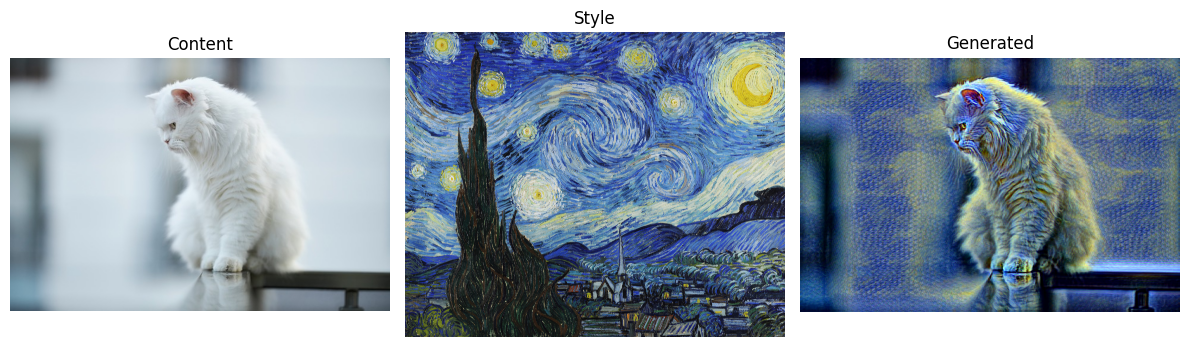

Version: Salt & Pepper


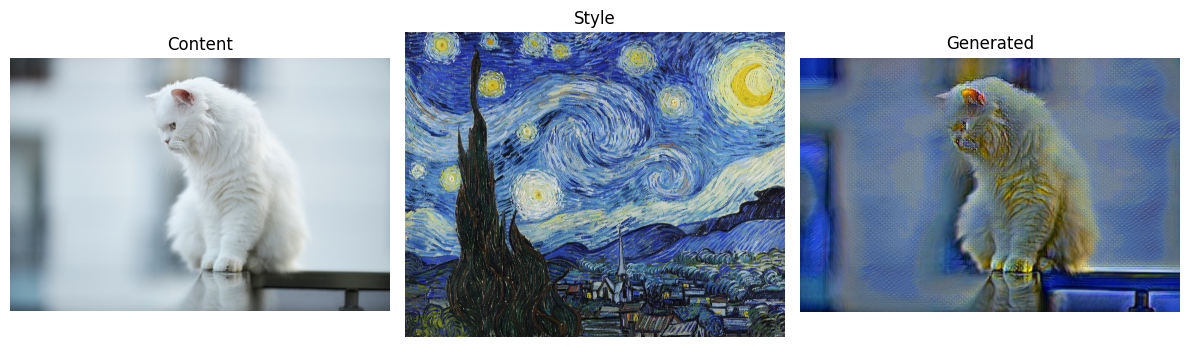

Version: Gaussian


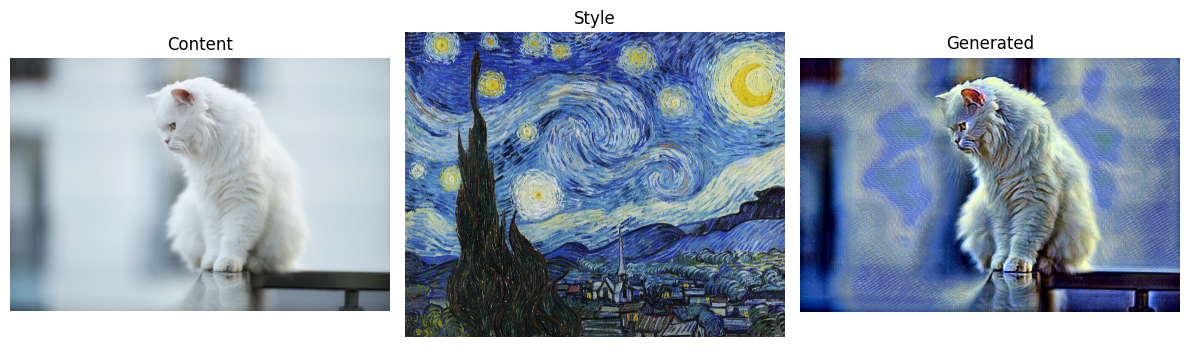

Version: No noise


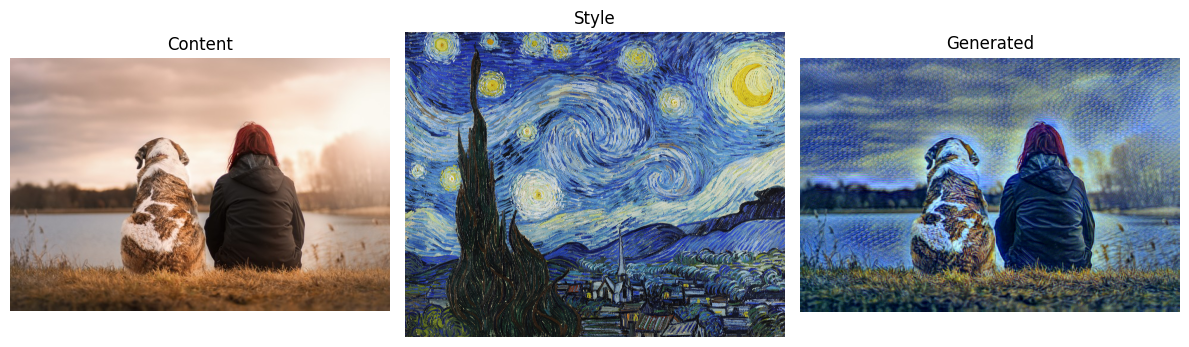

Version: Salt & Pepper


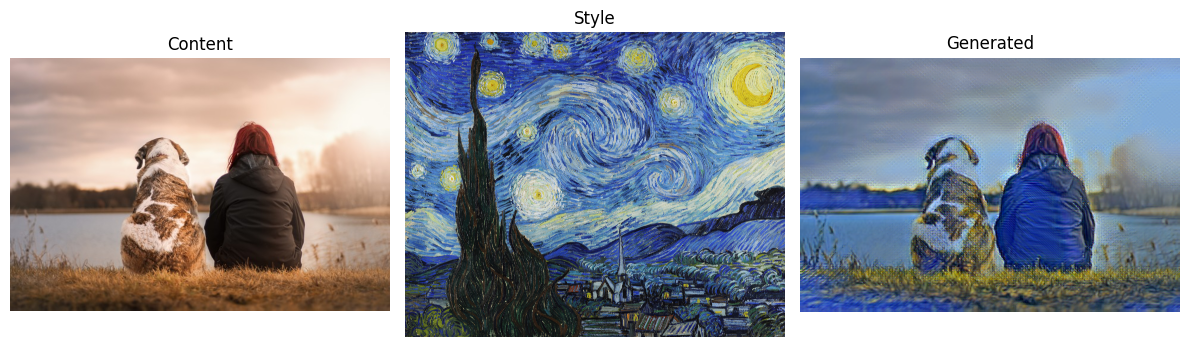

Version: Gaussian


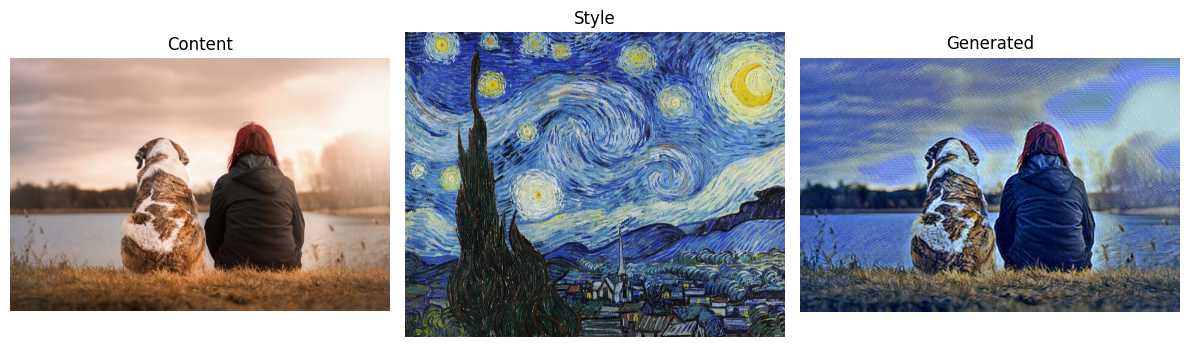

In [ ]:
style = Image.open(STYLE_IMG_PATH).convert("RGB")
img_style = transforms.ToTensor()(style).unsqueeze(0).to(device)

for i in range(1,3):
    content_img_name =  random.choice(os.listdir(content_imgs_path))
    content_img_path = os.path.join(content_imgs_path, content_img_name)
    content = Image.open(content_img_path).convert("RGB")
    sample_content = transforms.ToTensor()(content).unsqueeze(0).to(device)
    for name, model in models_dict.items():
        with torch.no_grad():
            sample_gen = model(sample_content)

        sample_gen = sample_gen.squeeze(0).clamp(0,255).cpu()

        print(f"Version: {name}")
        show_triplet(
            content=sample_content,
            style=img_style,
            generated=sample_gen
        )

    # cleanup to avoid saturating the RAM
    del sample_gen
    plt.close("all")
    gc.collect()
    torch.cuda.empty_cache()

If we examine the generated images, we observe that all three models successfully capture and transfer the color palette of the style image. However, beyond color adaptation, clear qualitative differences emerge in terms of texture, sharpness, and content preservation.

The model trained without noise produces the sharpest stylization overall, with well-defined textures and strong preservation of the underlying content structure. Fine details and high-frequency patterns are clearly visible, indicating that the model effectively learns the style statistics. However, this sharpness comes at the cost of visible artifacts in several relatively uniform regions of the background.

The model trained with salt-and-pepper noise exhibits the weakest performance among the three. The resulting image appears noticeably blurred, with partial loss of content details and a diminished transfer of stylistic textures. This may suggest that salt-and-pepper noise interferes with the learning of coherent feature correlations required for effective style transfer.

In contrast, the model trained with Gaussian noise achieves a more favorable balance between stylization and content preservation. While slightly smoother than the no-noise result, the generated image maintains coherent stylistic patterns and the artifacts visible in the no-noise image here appear as brushstroke-like patterns. This may indicates that Gaussian noise could be an effective form of regularization during training.

## Final considerations

In this project, we implemented a feed-forward neural style transfer network based on the Instance Normalization paper.
The model was trained to transfer the style of a reference image onto a variety of content images while preserving their underlying structure, achieving fast and visually compelling stylization results.

Beyond reproducing the main results of the original paper, we investigated the effect of noise injection on the content images during training. In particular, we analyzed how salt-and-pepper noise and gaussian noise influence the quality of the generated outputs.

Our experimental results show that noise can significantly impact stylization quality, either improving or degrading the final results depending on its characteristics.
Salt-and-pepper noise, due to its sparse and high-contrast nature, interferes with the learning process and leads to blurred and less detailed stylizations.
In contrast, Gaussian noise, being dense and composed of small perturbations, acts as a mild form of regularization, encouraging smoother texture synthesis.

# Miscellaneous

In [ ]:
import glob
import zipfile

files = glob.glob("/content/best_style_net*")

with zipfile.ZipFile("best_style_net_files.zip", "w") as z:
    for f in files:
        z.write(f)

print(f"Zipped {len(files)} files.")

In [ ]:
from google.colab import files
files.download("best_style_net_files.zip")